Fonte/créditos: https://pt.d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1
!pip install mxnet


# Machine Translation and the Dataset
:label:`sec_machine_translation`

Among the major breakthroughs that prompted
widespread interest in modern RNNs
was a major advance in the applied field of
statistical  *machine translation*.
Here, the model is presented with a sentence in one language
and must predict the corresponding sentence in another.
Note that here the sentences may be of different lengths,
and that corresponding words in the two sentences
may not occur in the same order,
owing to differences
in the two language's grammatical structure.


Many problems have this flavor of mapping
between two such "unaligned" sequences.
Examples include mapping
from dialog prompts to replies
or from questions to answers.
Broadly, such problems are called
*sequence-to-sequence* (seq2seq) problems
and they are our focus for
both the remainder of this chapter
and much of :numref:`chap_attention-and-transformers`.

In this section, we introduce the machine translation problem
and an example dataset that we will use in the subsequent examples.
For decades, statistical formulations of translation between languages
had been popular :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`,
even before researchers got neural network approaches working
(methods were often lumped together under the term *neural machine translation*).


First we will need some new code to process our data.
Unlike the language modeling that we saw in :numref:`sec_language-model`,
here each example consists of two separate text sequences,
one in the source language and another (the translation) in the target language.
The following code snippets will show how
to load the preprocessed data into minibatches for training.


In [ ]:
import os
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

In [ ]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [ ]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [ ]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

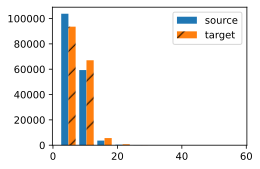

In [ ]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [ ]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [ ]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [ ]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1)
    return array, valid_len

In [ ]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=200):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.astype(np.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.astype(np.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: [[ 9  5  1  3  4  4  4  4]
 [ 5 62  0  3  4  4  4  4]]
valid lengths for X: [4 4]
Y: [[55 29  1  3  4  4  4  4]
 [ 5  0  3  4  4  4  4  4]]
valid lengths for Y: [4 3]
